**Load baseline LogisticRegression Model**

In [2]:
import joblib

baseline_model=joblib.load("../models/baseline_logreg.pkl")
tfidf_vectorizer=joblib.load("../models/tfidf_vectorizer.pkl")

print("Baseline Model Loaded")

Baseline Model Loaded


**Load fine-tuned BERT Model**

In [3]:
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification

bert_path="../models/final_model"

tokenizer=DistilBertTokenizerFast.from_pretrained(bert_path)
bert_model=DistilBertForSequenceClassification.from_pretrained(bert_path)

bert_model.eval()
print("BERT Model Loaded")

BERT Model Loaded


**Validation Data**

In [2]:
import pandas as pd

val_df=pd.read_csv('../data/processed/val_baseline.csv')


In [9]:
val_df.isna().sum()


text     31
label     0
dtype: int64

In [ ]:
val_df = val_df.dropna(subset=["text"]).reset_index(drop=True)

In [13]:
X_val_text=val_df['text'].values
y_true=val_df['label'].values

**Baseline Model Predictions**

In [14]:
X_val_tfidf=tfidf_vectorizer.transform(X_val_text)
baseline_preds=baseline_model.predict(X_val_tfidf)

**Baseline Evaluation**

In [15]:
from sklearn.metrics import classification_report,accuracy_score

print("Baseline Logistic Regression Model Results:\n")
print(classification_report(y_true, baseline_preds))
print("Accuracy:", accuracy_score(y_true, baseline_preds))

Baseline Logistic Regression Model Results:

              precision    recall  f1-score   support

           0       0.76      0.82      0.79       768
           1       0.88      0.91      0.90      3241
           2       0.78      0.62      0.69      3078
           3       0.65      0.70      0.68      2131
           4       0.51      0.68      0.58       517
           5       0.78      0.82      0.80       556
           6       0.56      0.79      0.66       215

    accuracy                           0.76     10506
   macro avg       0.70      0.76      0.73     10506
weighted avg       0.77      0.76      0.76     10506

Accuracy: 0.7585189415572055


**BERT Model Predictions**

Tokenize validation text

In [18]:
import torch
import numpy as np
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model.to(device)
bert_model.eval()

def bert_predict_fast(texts, batch_size=16):
    preds = []

    texts = texts.tolist()  # IMPORTANT

    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i+batch_size]

        enc = tokenizer(
            batch,
            padding=True,
            truncation=True,
            max_length=64,   # 🔥 REDUCED
            return_tensors="pt"
        )

        enc = {k: v.to(device) for k, v in enc.items()}

        with torch.no_grad():
            outputs = bert_model(**enc)
            logits = outputs.logits
            batch_preds = torch.argmax(logits, dim=1)

        preds.extend(batch_preds.cpu().numpy())

    return np.array(preds)


In [19]:
test_preds = bert_predict_fast(X_val_text[:200])


100%|██████████| 13/13 [00:14<00:00,  1.08s/it]


**Run BERT Prediction**

In [20]:
bert_preds=bert_predict_fast(X_val_text)

100%|██████████| 657/657 [13:43<00:00,  1.25s/it]


**BERT evalluation**

In [21]:
print("BERT Model Results:\n")
print(classification_report(y_true, bert_preds))    
print("Accuracy:", accuracy_score(y_true, bert_preds))


BERT Model Results:

              precision    recall  f1-score   support

           0       0.85      0.81      0.83       768
           1       0.91      0.94      0.92      3241
           2       0.72      0.73      0.73      3078
           3       0.67      0.63      0.65      2131
           4       0.56      0.66      0.60       517
           5       0.87      0.79      0.83       556
           6       0.71      0.59      0.64       215

    accuracy                           0.78     10506
   macro avg       0.75      0.74      0.74     10506
weighted avg       0.78      0.78      0.78     10506

Accuracy: 0.7771749476489624


**Metric comparison**

In [22]:
from sklearn.metrics import f1_score

comparison_df = pd.DataFrame({
    "Model": ["Logistic Regression", "DistilBERT"],
    "Accuracy": [
        accuracy_score(y_true, baseline_preds),
        accuracy_score(y_true, bert_preds)
    ],
    "Macro F1": [
        f1_score(y_true, baseline_preds, average="macro"),
        f1_score(y_true, bert_preds, average="macro")
    ],
    "Weighted F1": [
        f1_score(y_true, baseline_preds, average="weighted"),
        f1_score(y_true, bert_preds, average="weighted")
    ]
})

comparison_df


,Model,Accuracy,Macro F1,Weighted F1
0,Logistic Regression,0.758519,0.726939,0.758060
1,DistilBERT,0.777175,0.743437,0.776439


**Class-wise improvement analysis**

In [23]:
baseline_report = classification_report(
    y_true, baseline_preds, output_dict=True
)
bert_report = classification_report(
    y_true, bert_preds, output_dict=True
)

class_comparison = []

for cls in range(7):
    class_comparison.append({
        "Class": cls,
        "Baseline_F1": baseline_report[str(cls)]["f1-score"],
        "BERT_F1": bert_report[str(cls)]["f1-score"]
    })

pd.DataFrame(class_comparison)


,Class,Baseline_F1,BERT_F1
0,0,0.786432,0.829236
1,1,0.898392,0.922005
2,2,0.688145,0.726890
3,3,0.677492,0.649288
4,4,0.582090,0.604775
5,5,0.799650,0.827195
6,6,0.656371,0.644670


**Visualization: Model comparison**

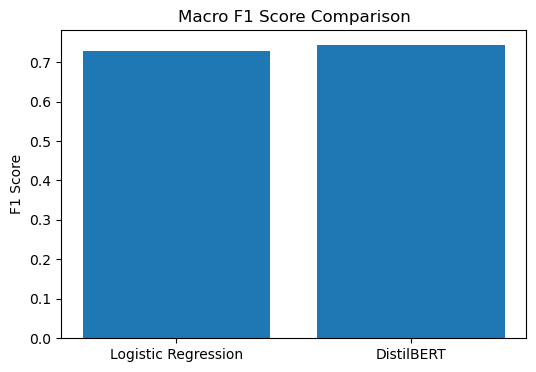

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.bar(comparison_df["Model"], comparison_df["Macro F1"])
plt.title("Macro F1 Score Comparison")
plt.ylabel("F1 Score")
plt.show()
